In [1]:
import qutip as qt
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import time

from scipy import optimize
from scipy.optimize import minimize
from scipy.integrate import solve_ivp
from scipy.linalg import sqrtm

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

#### parallelization 
options = qt.Options(num_cpus=6)


In [2]:

### Setup matplotlib

plt.rcParams.update({
    "text.usetex": True,
    "mathtext.fontset" : "stix",
    "font.family" : "Times New Roman", 
    "text.latex.preamble": r"\usepackage[T1]{fontenc} \usepackage{lmodern} \usepackage{amsmath} \usepackage{amstext}  \usepackage{amsfonts}",
    #
    "savefig.dpi" : 300,
    "xtick.minor.visible": True, 
    "ytick.minor.visible": True,
    
    "ytick.right": True,
    "ytick.left": True,

    "xtick.top": True,
    "xtick.bottom": True,
 
    #
    "xtick.direction": "in",
    "ytick.direction": "in",
    #
    "xtick.major.width": 1.5,     # major tick width in points
    "ytick.major.width": 1.5,     # major tick width in points
    #
    "xtick.minor.width": 1.5,     # minor tick width in points
    "ytick.minor.width": 1.5,     # minor tick width in points
    #
    "xtick.major.pad": 3.0,     # distance to major tick label in points
    "ytick.major.pad": 3.0,     # distance to major tick label in points
    #
    "xtick.minor.pad": 1.5,     # distance to the minor tick label in points
    "ytick.minor.pad": 1.5,     # distance to the minor tick label in points
    #
    "xtick.major.size": 3.0, 
    "ytick.major.size": 3.0,
    
    "xtick.minor.size": 3.0, 
    "ytick.minor.size": 3.0,
    #
    "xtick.labelsize": 20, 
    "ytick.labelsize": 20,
    #
    "legend.frameon": True, 
    "legend.fontsize": 20, 
    "legend.edgecolor": "black",
    "axes.titlesize": 20, 
    "axes.titleweight": "bold",
    "axes.labelsize":20 
})

##############
####### 
### Functions for evaluating the dominant eigenvalue

In [3]:


def Get_maximum(vector):
    """
    This function returns the maximum value and the corresponding index in a given vector.
    
    Parameters:
    vector: array-like 
        Input vector to search for the maximum value. 
    
    Returns: 
    max_value: float
        Maximum value found in the input vector.
    aux_idx: int
        Index of the maximum value in the input vector.
    """
    
    # Initialize variables for index and maximum value
    aux_idx = 0
    max_value = -np.Infinity
    
    # Enumerate through the vector, checking each value
    for idx, value in enumerate(vector):
        
        # If the current maximum value is greater than the real part of the current value
        if np.real(max_value) < np.real(value): 
            
            # Update the maximum value and the corresponding index
            max_value = value
            aux_idx = idx
            
    # Return the maximum value and its index
    return max_value, aux_idx



def Numeric_diagonalization(Ws, side="left"):
    """
    This function performs the numeric diagonalization of a given matrix, 
    returning the maximum eigenvalue and the corresponding eigenvector.

    Parameters:
    Ws: array-like
        Matrix to be diagonalized. 

    Returns:
    e_values[idx]: float
        Dominant (maximum) eigenvalue of the matrix.
    e_rightvectors[idx]: array-like
        Eigenvector corresponding to the dominant eigenvalue.
    """
    # Calculate the eigenvalues and left eigenvectors of the transpose of the input matrix
    if side == "left":
        e_values, e_vectors = np.linalg.eig(np.conjugate(Ws).T)
    elif side == "right":
        e_values, e_vectors = np.linalg.eig(Ws)
    else: raise ValueError('You have to choose or left or right')
         
    # Get the maximum eigenvalue and its corresponding index
    dominant_e, idx = Get_maximum(e_values)

    # Get dimension
    d = int(np.sqrt(np.shape(Ws)[0]))
    
    # reshaping the result
    e_mat = np.reshape(e_vectors[:,idx], (d,d))
        
    # Return the dominant eigenvalue and corresponding (left or right) eigen matrix
    return e_values[idx], e_mat/np.trace(e_mat)


###############
####### Coding 
###############

In [4]:
def entropy_prod_current(t, jump, args):
    ### if hot bath
    if jump < 8:
        ### if energetic transition
        if jump in [2,3,4,5]:
            return -args["beta_h"](t, args)*(args["omega"] + args["Omega"])
        else: 
            return -args["beta_h"](t, args)*(args["omega"] - args["Omega"])
    ### if cold bath
    else:
        ### if energetic transition
        if jump in [10, 11, 12, 13]:
            return args["beta_h"](t, args)*(args["omega"] + args["Omega"])
        else: 
            return args["beta_h"](t, args)*(args["omega"] - args["Omega"])
        

def organize_jumps(col_times, col_which, Nboxes, args):
    # Set dt
    dt = args["tau"]/(Nboxes)
    # Initialize N empty arrays
    times = [[] for _ in range(Nboxes)]
    jumps = [[] for _ in range(Nboxes)]
    entropy_current = [0 for _ in range(Nboxes)]
    
    # Organize time instants into arrays
    for i, t in enumerate(col_times):
        n = int(t // dt)
        times[n].append(t)
        jumps[n].append(col_which[i])
        entropy_current[n] += entropy_prod_current(t, col_which[i], args)
    return times, jumps, entropy_current

In [5]:
# Define the states
ket00 = qt.tensor(qt.basis(2,1), qt.basis(2,1))
ket01 = qt.tensor(qt.basis(2,1), qt.basis(2,0))
ket10 = qt.tensor(qt.basis(2,0), qt.basis(2,1))
ket11 = qt.tensor(qt.basis(2,0), qt.basis(2,0))

sigmam_h = qt.tensor(qt.sigmam(), qt.qeye(2))
sigmam_c = qt.tensor(qt.qeye(2), qt.sigmam())
sigmap_h = qt.tensor(qt.sigmap(), qt.qeye(2))
sigmap_c = qt.tensor(qt.qeye(2), qt.sigmap())

sigmax_h = qt.tensor(qt.sigmax(), qt.qeye(2))
sigmax_c = qt.tensor(qt.qeye(2), qt.sigmax())

sigmaz_h = qt.tensor(qt.sigmaz(), qt.qeye(2))
sigmaz_c = qt.tensor(qt.qeye(2), qt.sigmaz())

eps0 = ket00
eps1 = np.sqrt(1/2)*(ket01 - ket10)
eps2 = np.sqrt(1/2)*(ket01 + ket10)
eps3 = ket11
    
##### Transitions 
    
J_01 = eps0 * eps1.dag()
    
J_10 = eps1 * eps0.dag() 
        
J_02 = eps0 * eps2.dag()
    
J_20 = eps2 * eps0.dag()
    
J_13 = eps1 * eps3.dag()

J_31 = eps3 * eps1.dag()

J_23 = eps2 * eps3.dag()
    
J_32 = eps3 * eps2.dag()


In [6]:
########## Rates 

##### hot bath
def J_01_h_rate(t, args): 
    return (np.sqrt(args["alpha_h"] * (args["omega"] - args["Omega"]) ** 3 
                    * (1 + 1 / (np.exp(args["beta_h"](t, args) * (args["omega"] - args["Omega"])) - 1))) ) 
    
def J_10_h_rate(t, args):
    return (np.sqrt(args["alpha_h"] * (args["omega"] - args["Omega"]) ** 3 
                    * (0 + 1 / (np.exp(args["beta_h"](t, args) * (args["omega"] - args["Omega"])) - 1)))) 
    
def J_02_h_rate(t, args):
    return (np.sqrt(args["alpha_h"] * (args["omega"] + args["Omega"]) ** 3 
                    * (1 + 1 / (np.exp(args["beta_h"](t, args) * (args["omega"] + args["Omega"])) - 1)))) 
    
def J_20_h_rate(t, args):
    return (np.sqrt(args["alpha_h"] * (args["omega"] + args["Omega"]) ** 3 
                    * (0 + 1 / (np.exp(args["beta_h"](t, args) * (args["omega"] + args["Omega"])) - 1))))     
    
def J_13_h_rate(t, args):
    return (np.sqrt(args["alpha_h"] * (args["omega"] + args["Omega"]) ** 3 
                    * (1 + 1 / (np.exp(args["beta_h"](t, args) * (args["omega"] + args["Omega"])) - 1))))
    
def J_31_h_rate(t, args):
    return (np.sqrt(args["alpha_h"] * (args["omega"] + args["Omega"]) ** 3 
                    * (0 + 1 / (np.exp(args["beta_h"](t, args) * (args["omega"] + args["Omega"])) - 1)))) 
    
def J_23_h_rate(t, args):
    return (np.sqrt(args["alpha_h"] * (args["omega"] - args["Omega"]) ** 3 
                    * (1 + 1 / (np.exp(args["beta_h"](t, args) * (args["omega"] - args["Omega"])) - 1))))
       
def J_32_h_rate(t, args):
    return (np.sqrt(args["alpha_h"] * (args["omega"] - args["Omega"]) ** 3 
                    * (0 + 1 / (np.exp(args["beta_h"](t, args) * (args["omega"] - args["Omega"])) - 1))))
    
##### cold bath
    
def J_01_c_rate(t, args): 
    return (np.sqrt(args["alpha_c"] * (args["omega"] - args["Omega"]) ** 3 
                    * (1 + 1 / (np.exp(args["beta_c"] * (args["omega"] - args["Omega"])) - 1))) ) 

def J_10_c_rate(t, args):
    return (np.sqrt(args["alpha_c"] * (args["omega"] - args["Omega"]) ** 3 
                    * (0 + 1 / (np.exp(args["beta_c"] * (args["omega"] - args["Omega"])) - 1)))) 
    
def J_02_c_rate(t, args):
    return (np.sqrt(args["alpha_c"] * (args["omega"] + args["Omega"]) ** 3 
                    * (1 + 1 / (np.exp(args["beta_c"] * (args["omega"] + args["Omega"])) - 1)))) 
    
def J_20_c_rate(t, args):
    return (np.sqrt(args["alpha_c"] * (args["omega"] + args["Omega"]) ** 3 
                    * (0 + 1 / (np.exp(args["beta_c"] * (args["omega"] + args["Omega"])) - 1))))     
    
def J_13_c_rate(t, args):
    return (np.sqrt(args["alpha_c"] * (args["omega"] + args["Omega"]) ** 3 
                    * (1 + 1 / (np.exp(args["beta_c"] * (args["omega"] + args["Omega"])) - 1))))
    
def J_31_c_rate(t, args):
    return (np.sqrt(args["alpha_c"] * (args["omega"] + args["Omega"]) ** 3 
                    * (0 + 1 / (np.exp(args["beta_c"] * (args["omega"] + args["Omega"])) - 1)))) 
    
def J_23_c_rate(t, args):
    return (np.sqrt(args["alpha_c"] * (args["omega"] - args["Omega"]) ** 3 
                    * (1 + 1 / (np.exp(args["beta_c"] * (args["omega"] - args["Omega"])) - 1))))
       
def J_32_c_rate(t, args):
    return (np.sqrt(args["alpha_c"] * (args["omega"] - args["Omega"]) ** 3 
                    * (0 + 1 / (np.exp(args["beta_c"] * (args["omega"] - args["Omega"])) - 1))))
    


In [7]:
#####
# Putting it into a list 
    
c_ops = [[J_01, J_01_h_rate], 
        [J_10, J_10_h_rate],
        [J_02, J_02_h_rate],  
        [J_20, J_20_h_rate],
        [J_13, J_13_h_rate],
        [J_31, J_31_h_rate], 
        [J_23, J_23_h_rate], 
        [J_32, J_32_h_rate], 
#####################################
        [J_01, J_01_c_rate],
        [J_10, J_10_c_rate], 
        [J_02, J_02_c_rate],
        [J_20, J_20_c_rate],
        [J_13, J_13_c_rate],
        [J_31, J_31_c_rate],
        [J_23, J_23_c_rate],
        [J_32, J_32_c_rate]]


In [15]:
####### Parameters 

omega = 1.0
alpha_h = 1.0
alpha_c = 1.0
beta0_h = 1.0/(2.0) # T = 2
beta_c = 1.0/(1.0) # T = 1
Omega = 0.5
g = 1.0


def beta_h(t, args):
    return 1/(1/args["beta0_h"] + np.sin(t*np.pi/args["tau"])**2)


############# Total dynamics time


tau = 1000
Nsteps = 100


############# Argumets dict 

args  = {"omega":omega,
         "Omega":Omega,
         "g":g,
         "alpha_h":alpha_h,
         "alpha_c":alpha_c,
         "beta_h":beta_h,
         "beta0_h":beta0_h,
         "beta_c":beta_c,
         "tau":tau}

In [16]:
####### Hamiltonian    
    
H0 = (Omega*( sigmam_h*sigmap_c + sigmap_h*sigmam_c) 
        + g*(sigmax_c + sigmax_h) 
        + (omega/2)*(sigmaz_c + sigmaz_h))

####### Initial state

psi0 = ket11.copy()

####### Time window 

tlist = np.linspace(0, tau, Nsteps)

In [17]:
ntraj=10
result = qt.mcsolve(H0, psi0, tlist, c_ops, args=args, ntraj=ntraj)

10.0%. Run time:  41.63s. Est. time left: 00:00:06:14
20.0%. Run time:  41.85s. Est. time left: 00:00:02:47
30.0%. Run time:  41.94s. Est. time left: 00:00:01:37
40.0%. Run time:  42.00s. Est. time left: 00:00:01:02
50.0%. Run time:  42.12s. Est. time left: 00:00:00:42
60.0%. Run time:  42.31s. Est. time left: 00:00:00:28
70.0%. Run time:  42.56s. Est. time left: 00:00:00:18
80.0%. Run time:  42.59s. Est. time left: 00:00:00:10
90.0%. Run time:  67.40s. Est. time left: 00:00:00:07
100.0%. Run time:  67.56s. Est. time left: 00:00:00:00
Total run time:  67.57s


In [18]:
Nboxes = 20

entropy_data = []
for traj in range(ntraj):
    times, jumps, entropy = organize_jumps(result.col_times[traj], result.col_which[traj], Nboxes, args)
    entropy_data.append(entropy)
    
entropy_data = np.array(entropy_data)

mean_values = np.mean(np.array(entropy_data).T, axis=1)
std_dev_values = np.std(np.array(entropy_data).T, axis=1)


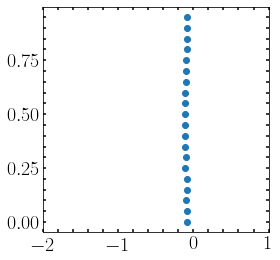

In [19]:

fig, ax = plt.subplots(1,1, figsize=(7, 3.5), 
                       layout='compressed')

ax.errorbar(mean_values/args["tau"], np.arange(Nboxes)/Nboxes, xerr=std_dev_values/args["tau"],  fmt="o")
ax.set_xlim(-2,1)


ax.set_box_aspect(1)
